```text
SPDX-License-Identifier: PolyForm-Noncommercial-1.0.0
Autor: Bruno Francisco Barra Atarama
Institución:
  Departamento de Ingeniería Aeroespacial
  Facultad de Ingeniería
  Universidad Nacional de La Plata
Año: 2025
Licencia: PolyForm Noncommercial License 1.0.0
```

**Licencia:** ver [LICENSE](../LICENSE).

# Ejemplo: ala con *flap*

En este ejemplo se muestra cómo configurar un conjunto de dos sólidos para simular los experimentos de una ala con *flap* del [NACA Report No. 614 (19930091690)](https://ntrs.nasa.gov/citations/19930091690).

## Bibliotecas y módulos

A continuación, se muestra qué bibliotecas se importan para este ejemplo particular.

El módulo de tipado se recomienda utilizar para aprovechar las ayudas documentadas, sobre todo en los primeros usos.

In [2]:
%matplotlib inline
# Para gráficos interactivos en el notebook. # Para utilizar, instalar ipympl con `pip install ipympl`
# %matplotlib widget    

# Bibliotecas generales
import numpy as np                          # Para hacer operaciones matemáticas
import matplotlib, matplotlib.pyplot as plt # Para graficar

# Módulos propios

# Funcionales
from src.MP2D import MP2D
from src import Cinematicas
from src.Importacion import discretizarPerfil

# Tipado
from src import Tipos

# Datos
from Ejemplos.rec.NACAR614 import datos

## Importación del perfil y construcción de los panelados

Se importan los perfiles desde archivos en formato selig en este caso, escalándolos según las cuerdas del experimento.

La coordenadas `r_xy_flap` todavía no son las finales, ya que queda posicionar el *flap* correctamente. Se retoma después.

In [3]:
cw = 0.508       # Cuerda del perfil principal
cf = 0.2 * cw    # Cuerda del perfil del flap

# Importación, escalado y discretización de los perfiles
ruta = 'rec/perfiles/NACA23012_selig.txt'   # Ruta al archivo con las coordenadas del perfil.

N = 400      # Número de paneles del perfil principal
NFlap = 200  # Número de paneles del perfil del flap

r_xy = discretizarPerfil(ruta, nIntrados=N//2, nExtrados=N//2, cuerda=cw, formato='selig', espaciamiento='cos', bordeDeFugaCerrado=True)
r_xy_flap = discretizarPerfil(ruta, nIntrados=NFlap//2, nExtrados=NFlap//2, cuerda=cf) # Utiliza los valores por defecto, que son los anteriores.

## Condiciones de los experimentos
Se definen las condiciones del flujo libre.

In [4]:
V = 35.76                       # Velocidad de avance en m/s, equivalente a las 80 millas por hora del experimento NACA.

refConfig: Tipos.RefConfig = {  # Posicionar el cursor sobre el tipo para más información.
    'l' : cw + cf,
    'V' : V,
    #'rho' : 1.225, # Se completan automáticamente con los valores por defecto, que son los mostrados.
    #'P' : 101325,
}

## Experimento 1: $\delta_f = 10°$, $\alpha\in\{-4,61°, 3,92°\}$

Aquí se posiciona el *flap* en relación al perfil principal y se construye la cinemática, tanto de los sólidos como la del punto de toma de momentos.

En este ejemplo, se considera como punto de toma de momentos al eje de rotación del *flap*, para mostrar cómo puede definirse este para obtener el coeficiente de momento de charnela.


In [5]:
alfa = [- 4.61, 3.92]   # Ángulo de ataque [°]. Se mide con el perfil principal.
df = 10                 # Deflexión del flap [°].

# -------------------------
# Cinemática de los sólidos
# -------------------------

# Posicionamiento del flap
flapParams: Cinematicas.FlapParams = { # Posicionar el cursor sobre el tipo para más información.
    'cf' : cf,
    'cw' : cw,
    'df' : df,
    'r_xy' : r_xy_flap,
    'h_ROTf_BAf' : 0.24,    # Cantidad adimensionalizada con cf
    'v_ROTf_MCf' : 0.1,     # Cantidad adimensionalizada con cf
    'h_TEw_ROTf' : 0.03,    # Cantidad adimensionalizada con cw
    'v_TEw_ROTf' : 0.054,   # Cantidad adimensionalizada con cw
}

r_xy_flap_1, r_ROT_xy_1 = Cinematicas.flap(flapParams)

# Ahora se anima al conjunto de movimiento rectilíneo uniforme, imponiendo el ángulo de ataque del experimento.
AOAParams: Tipos.AOAParams = {
    'alfa' : alfa,
    'r_xy' : r_xy,  # Coordenadas del perfil principal
    'V' : V,
}

AOAParams_flap: Tipos.AOAParams = {
    'alfa' : alfa,
    'r_xy' : r_xy_flap_1,  # Coordenadas del perfil del flap
    'V' : V,
}

# Se crean los generadores de cinemáticas.
cinematicas = [
    Cinematicas.cinematica('aoa', AOAParams),  
    Cinematicas.cinematica('aoa', AOAParams_flap)
]

# ------------------------------------
# Punto de toma de momentos (opcional)
# ------------------------------------

# En este caso, este eje se lo hace coincidir con el punto de giro del flap para visualizar el momento de charnela posteriormente.
RM = iter([Cinematicas.moverCoordenadas(r_ROT_xy_1, Dth=-alfa_i) for alfa_i in alfa])

### Simulación

Se configura el simulador en modo estacionario y se simula, siempre con la condición de Kutta impuesta.

In [6]:
# Se configura el simulador
mpConfig: Tipos.MPConfig = {
    'estacionario' : True,
    'vorticeArranque' : True,
    'nombres' : ['Ala', 'Flap']
}

mp = MP2D(cinematicas, RM, mpConfig, refConfig)

# Se simula
mp.simular()
print(f'Relaciones adimensionales calculadas:\n{mp.adimInfo}')

Simulando: 100%|██████████| 2/2 [00:00<00:00, 22.10 pasos/s]

Relaciones adimensionales calculadas:
{'Re': 1453286.4, 'Ma': 0.10508374963267704, 'Fr': 14.623136275176467, '_Re': 6.880956155648329e-07, '_Fr2': 0.004676478537002839, 'Ma2': 0.011042594436863153, 'Ma2_Re': 7.59836081646615e-09, 'Ma2_Fr2': 5.164045587681749e-05}


### a) $\alpha = -4,61°$

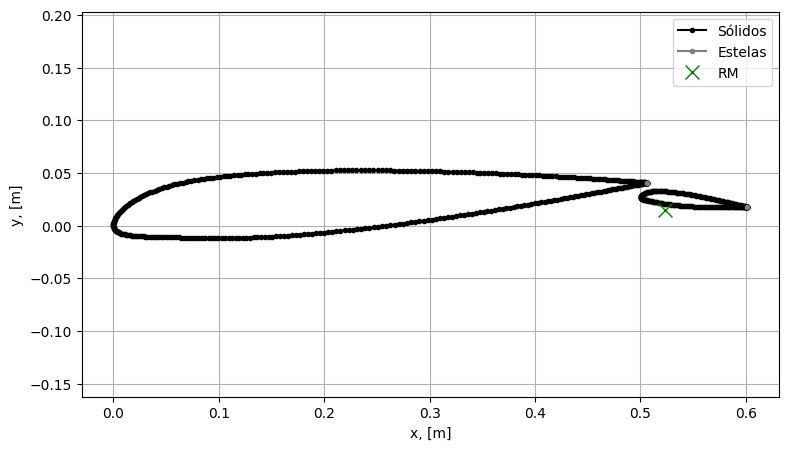

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
mp.plotPaneles(0, mostrarRM=True, ax=ax)
plt.show()

![df 10 a -4,61](rec/df_10_a_-4,61.png)

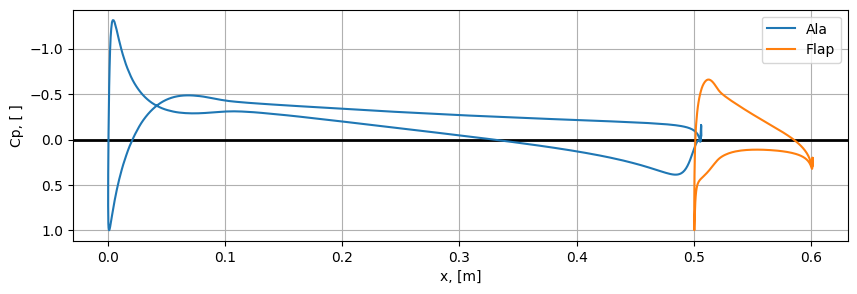

In [8]:
fig, ax_a = plt.subplots(1, 1, figsize=(10, 3))
mp.plotCp(0, ax_a)
plt.show()

En la distribución del $C_p$ de la simulación se advierte una sobreestimación de la succión en la zona anterior, una característica del flujo no viscoso. Existen ligeras diferencias en el resto de ubicaciones, pero hay gran correspondencia con los resultados empíricos.

### b) $\alpha = 3,92°$

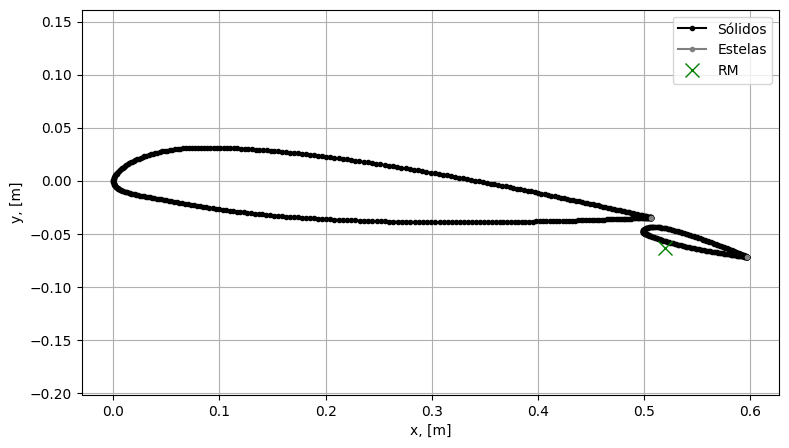

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 5))
mp.plotPaneles(1, mostrarRM=True, ax=ax)
plt.show()

![df 10 a 3,92](rec/df_10_a_3,92.png)

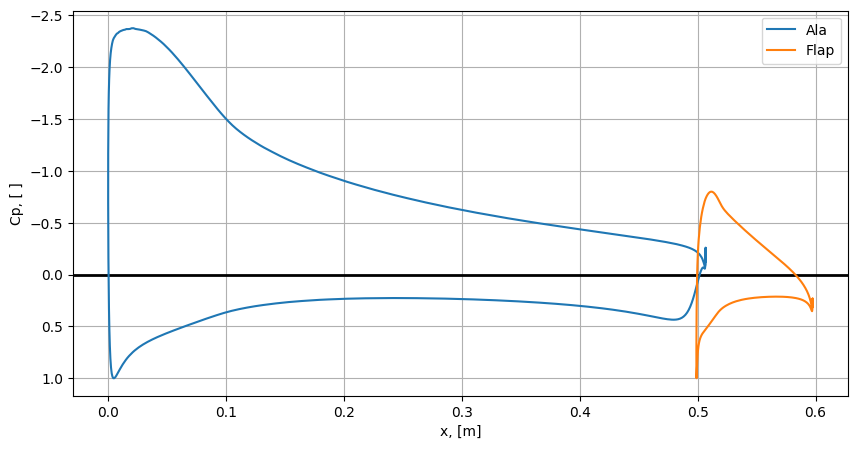

In [10]:
fig, ax_b = plt.subplots(1, 1, figsize=(10, 5))
mp.plotCp(1, ax_b)
plt.show()

Nuevamente se sobreestima la succión en la región anterior y la curva de $C_p$ es captada de forma satisfactoria por el método de los paneles.

## Experimento 2: comparación de polares

Ahora se extenderá el mismo procedimiento para elaborar las polares $C_n$ vs. $\alpha$ con las diferentes deflexiones evaluadas en el Report, para comparar con los resultados experimentales.

También se graficarán las curvas $C_h$ vs. $C_n$ con el mismo propósito.

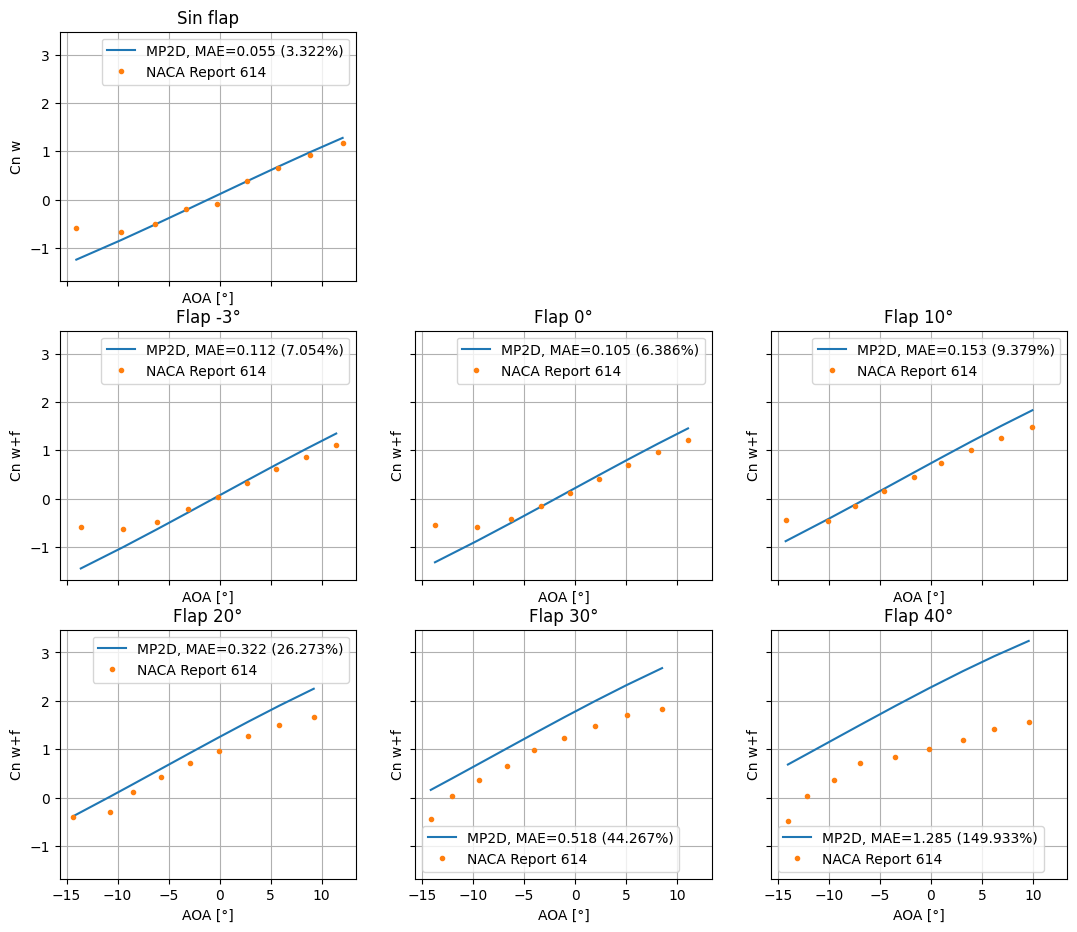

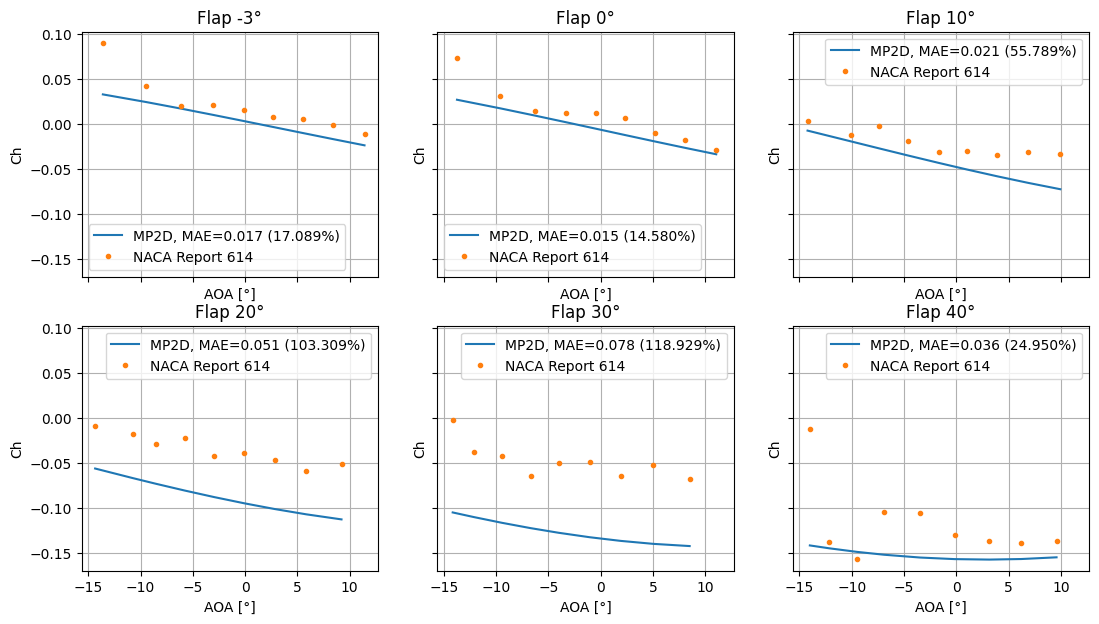

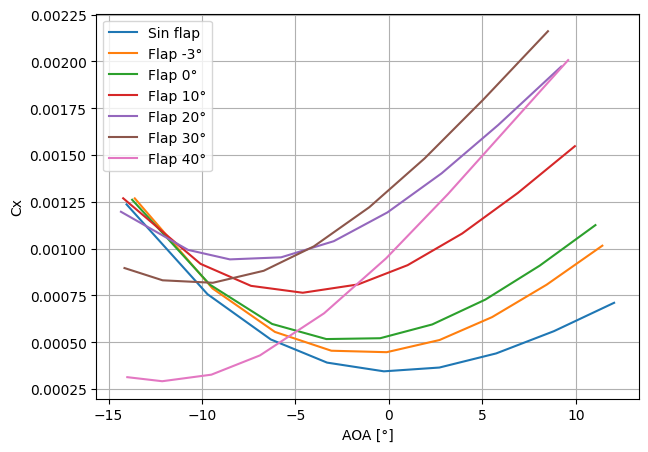

In [11]:
# Función para automatizar las simulaciones y la graficación.
from typing import Sequence, List, Tuple
def mae(y_true: Sequence, y_pred: Sequence)-> Tuple[float, float]:
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mae = np.mean(np.abs(y_pred - y_true))
    mae_100 = mae / (np.max(y_true) - np.min(y_true)) * 100
    return mae, mae_100

def polar(
        df: float | None,
        alfa : Sequence,
        ax : plt.Axes,
        Cn_dato: List[float],
        Ch_dato: List[float],
):
    AOAParams: Tipos.AOAParams = {
        'alfa' : alfa,
        'r_xy' : r_xy,  # Coordenadas del perfil principal
        'V' : V,
    }

    cinematicas = [Cinematicas.cinematica('aoa', AOAParams)]

    RM = None   # En el caso de que no haya flap

    if df is not None:  # Si hay flap
        flapParams: Cinematicas.FlapParams = { # Posicionar el cursor sobre el tipo para más información.
            'cf' : cf,
            'cw' : cw,
            'df' : df,
            'r_xy' : r_xy_flap,
            'h_ROTf_BAf' : 0.24,    # Cantidad adimensionalizada con cf
            'v_ROTf_MCf' : 0.1,     # Cantidad adimensionalizada con cf
            'h_TEw_ROTf' : 0.03,    # Cantidad adimensionalizada con cw
            'v_TEw_ROTf' : 0.054,   # Cantidad adimensionalizada con cw
        }

        r_xy_flap_2, r_ROT_xy_2 = Cinematicas.flap(flapParams)

        AOAParams_flap: Tipos.AOAParams = {
        'alfa' : alfa,
        'r_xy' : r_xy_flap_2,  # Coordenadas del perfil del flap
        'V' : V,
        }

        cinematicas.append(Cinematicas.cinematica('aoa', AOAParams_flap))
    
        RM = iter([Cinematicas.moverCoordenadas(r_ROT_xy_2, Dth=-alfa_i) for alfa_i in alfa])

    mpConfig['rotulo_t'] = 'AOA [°]'
    mpConfig['mostrarProgreso'] = False
    mp = MP2D(cinematicas, RM, mpConfig, refConfig)

    mp.simular()

    # Graficación
    Cn = []
    Cx = []
    for i, (cx, cy) in enumerate(mp.CxyTotalRec):
        a = np.deg2rad(alfa[i])
        Cn.append(-np.sin(a) * cx + np.cos(a) * cy)
        Cx.append(cx)

    masc = (np.array(alfa) > - 8)
    mae_Cn, mae_Cn_100 = mae(np.array(Cn_dato)[masc], np.array(Cn)[masc])
    
    ax[1].plot(alfa, Cn, label=f'MP2D, MAE={mae_Cn:.3f} ({mae_Cn_100:.3f}%)')
    ax[0].plot(alfa, Cx)

    ax[0].grid(True)
    ax[1].grid(True)
    
    if df is not None:
        Ch = [Cm[1] * (cw + cf) ** 2 / cf ** 2 for Cm in mp.CmRec]
        mae_Ch, mae_Ch_100 = mae(Ch_dato, Ch)
        ax[2].plot(alfa, Ch, label=f'MP2D, MAE={mae_Ch:.3f} ({mae_Ch_100:.3f}%)')
        ax[2].grid(True)
    
# Simulación y gráficos.
nombres: List[str] = list(datos.keys())

fig_Cn, axs_Cn = plt.subplots(3, 3, figsize=(13, 11), sharey=True, sharex=True)
fig_Ch, axs_Ch = plt.subplots(2, 3, figsize=(13, 7), sharey=True, sharex=True)

fig_Cx, ax_Cx = plt.subplots(1, 1, figsize=(7, 5))

axs_Cn = axs_Cn.ravel()
axs_Ch = axs_Ch.ravel()

for i, nombre in enumerate(nombres):
    alfa = datos[nombre]['alfa']
    if nombre == 'Sin flap':
        ax_Cn = axs_Cn[i]
        ax_Ch = None

        df = None
        Cn_dato = datos[nombre]['Cnw']
        Ch_dato = None
        ax_Cn.set_ylabel('Cn w')
    else:
        ax_Cn = axs_Cn[i + 2]
        ax_Ch = axs_Ch[i - 1]

        df = float(nombre.split()[1].replace('°', ''))

        Cn_dato = datos[nombre]['Cn w+f']
        Ch_dato = datos[nombre]['Ch']

        ax_Cn.set_ylabel('Cn w+f')

        ax_Ch.set_title(nombre)
        ax_Ch.set_ylabel('Ch')
        ax_Ch.set_xlabel('AOA [°]')
        

    ax_Cn.set_xlabel('AOA [°]')
    axs = [ax_Cx, ax_Cn, ax_Ch]
    polar(df, alfa, ax=axs, Cn_dato=Cn_dato, Ch_dato=Ch_dato)

    ax_Cn.plot(alfa, Cn_dato, marker='o', linestyle='none', markersize=3, label='NACA Report 614')
    
    ax_Cn.set_title(nombre)
    ax_Cn.legend()

    if ax_Ch is not None:
        ax_Ch.plot(alfa, Ch_dato, marker='o', linestyle='none', markersize=3, label='NACA Report 614')
        ax_Ch.legend()

fig_Cn.delaxes(axs_Cn[1]), fig_Cn.delaxes(axs_Cn[2])

ax_Cx.set_xlabel('AOA [°]')
ax_Cx.set_ylabel('Cx')
ax_Cx.legend(nombres)
ax_Cx.grid(True)


### Comentarios de las curvas
1. $C_n$ vs. $\alpha$ (o $C_{n, w+f}$ vs. $\alpha$)

    Entre los resultados de la simulación y los experimentos en túnel de viento existe gran correspondencia en la parte lineal de las polares sin *flap* y con *flap* deflectado -3°, 0° y 10°.

    Para ángulos de ataque fuera de la región lineal y mayores deflexiones, las discrepancias aumentan. Esto tiene sentido, pues la simulación resuelve un flujo potencial, por lo que predice picos de succión mayores y no capta, por ejemplo, la interferencia de las capas límite de los perfiles en la ranura, que tiende a decelerar el flujo allí.

2. $C_h$ vs. $C_{n, w+f}$

    Esta comparación sigue la tendencia, aunque en los casos donde el flujo potencial es más aplicable hay discrepancias mayores.

    Las principales contribuciones a estas diferencias, además del modelo potencial, son:
    
    - El método de los paneles con dobletes constantes discretiza la distribución de presiones de forma constante en cada panel, modificando tanto el módulo de la resultante aerodinámica en cada panel, como su recta de acción.

    - El método utilizado para relevar los valores del coeficiente de charnela: a diferencia de los otros datos, en este caso se recurrió a la extracción de los valores a partir de la digitalización de las curvas.

    - El método de cálculo utilizado en el Report: se utilizó integración mecánica a partir de la geometría del perfil y la presiones medidas en orificios presentes en los perfiles durante los experimentos.

3. $C_x$ vs $\alpha$

    En este caso, no se contrasta el coeficiente con datos experimentales.

    Como la velocidad relativa del perfil al fluido en reposo tiene dirección $x$, el coeficiente $C_x$ se corresponde con el $C_d$.

    El $C_d$ en flujo potencial se puede demostrar que es nulo en flujo estacionario. Sin embargo, el gráfico no muestra esto.

    Esto se atribuye a la discretización del perfil y la utilización de dobletes constantes como singularidades, que dificulta la representación de la continuidad de la distribución de singularidades.

    Cambiando la densidad del modelado, se puede notar cómo cambia la magnitud de las curvas obtenidas. Esta falta de consistencia apoya la idea de que la presencia de un $C_x$ no nulo es un error numérico del método.

## Conclusión

Antes de seguir con el último experimento, que ya no ofrece contrastes con datos externos, en base a las curvas de $C_p$ expuestas y las polares graficadas, puede decirse que el esquema estacionario de la implementación desarrollada alcanza gran correlación con resultados experimentales en un problema multielemento. 

El método comienza a producir peores estimaciones a mayores deflexiones del *flap*, debido a los mayores efectos viscosos que ocurren tanto en la succión del perfil principal como en el canal entre el perfil principal y el *flap*. 

En este caso no ocurrió, por la configuración utilizada en el NACA Report No. 614, pero en problemas donde la separación entre los perfiles es menor, el método potencial y por lo tanto el método de los paneles, predice grandes velocidades, lo cual en la realidad se ve atenuada por la interacción de las capas límite de ambos sólidos.

## Experimento 3: simulación estacionaria con desarrollo temporal

Ahora, considerando el caso $df = 10°$ y $\alpha = 3,92°$, se realizará una simulación durante algunos instantes, para realizar algunas visualizaciones, y también algunos comentarios.
### Simulación

In [12]:
# Vector de tiempos

DtUinf_c = 0.002
tUinf_c_final = 0.2

Dt = DtUinf_c * cw / V
tFinal = tUinf_c_final * cw / V
t = np.arange(0, tFinal, Dt)

# Cinemáticas
alfa_3 = 3.92
r_xy_flap_3 = r_xy_flap_1

params_3: Cinematicas.MRUParams = {
    'alfa' : alfa_3,
    'r_xy' : r_xy,
    't' : t,
    'V' : V,
}

params_flap_3: Cinematicas.MRUParams = {
    'alfa' : alfa_3,
    'r_xy' : r_xy_flap_3,
    't' : t,
    'V' : V,
}

cinematicas = [
    Cinematicas.cinematica('mru', params_3, rutaBase='rec/ala'),        # Se guarda la cinemática en un .npz. `rutaBase` no lleva la extensión.
    Cinematicas.cinematica('mru', params_flap_3, rutaBase='rec/flap')   # Se guarda la cinemática en un .npz. `rutaBase` no lleva la extensión.
]

mpConfig: Tipos.MPConfig= {
    'nombres' : ['Ala', 'Flap'],
    'estacionario' : False,
    'vorticeArranque' : True,
    'rigidez' : 1,
    'mostrarProgreso': True
}

mp = MP2D(cinematicas, mpConfig=mpConfig, refConfig=refConfig)

mp.simular()

Simulando: 100%|██████████| 101/101 [00:09<00:00, 10.82 pasos/s]


Cuando se definió la lista `cinemáticas` en el código anterior, se especificó el argumento `rutaBase`, la cual es la ruta (sin extensión) a archivos `.npz` donde se almacenarán las cinemáticas generadas. Esto se realiza para posteriormente cargarlas en el [ejemplo de carga y guardado correspondiente](ejemploCargaYGuardado.ipynb) .

### Cp vectorial

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


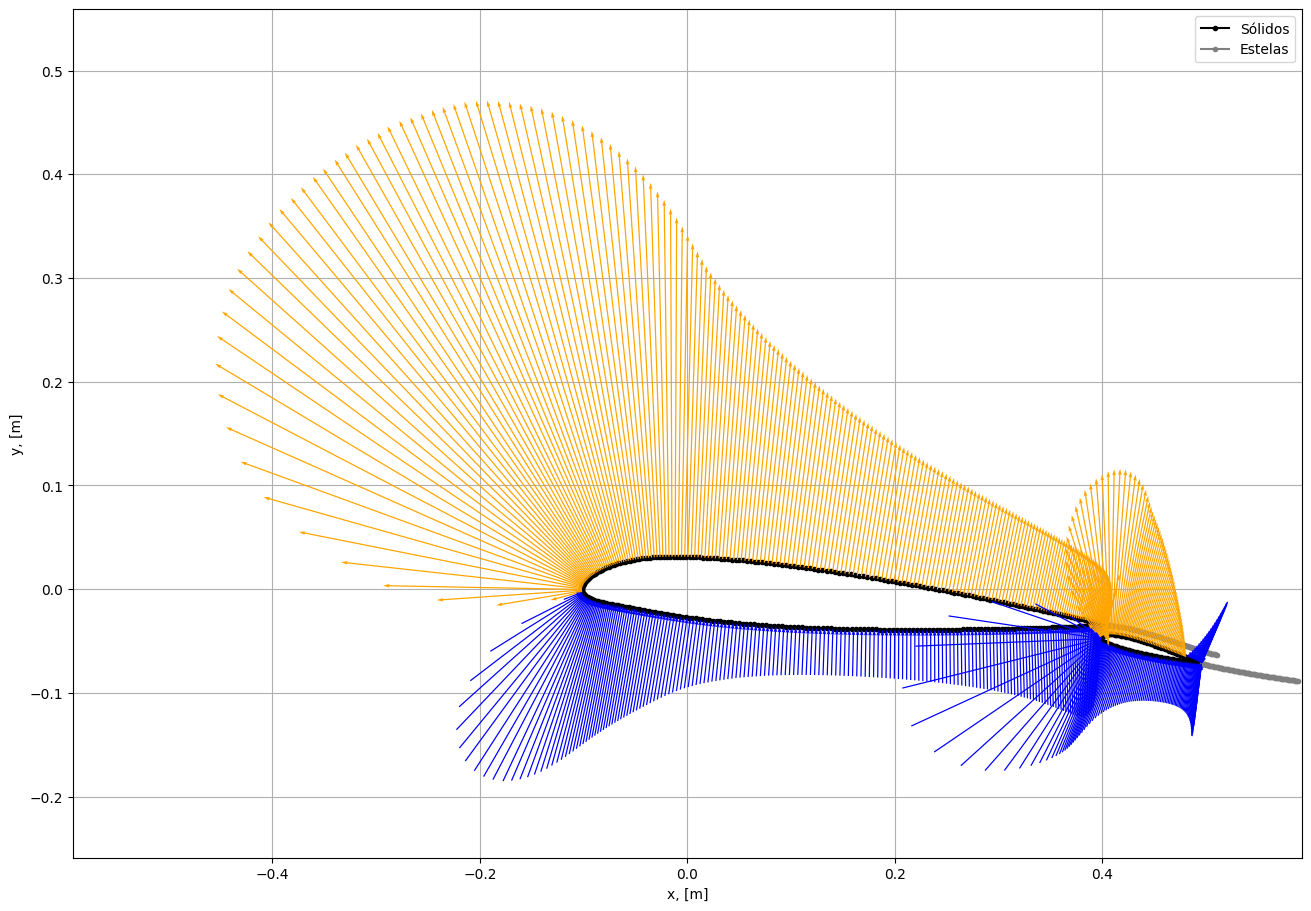

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(13, 9), constrained_layout=True)
ax = mp.plotCpVect(it=-1, ax=ax, escala=0.2)
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.3, 0.6)
plt.show()

### Coeficientes aerodinámicos

A continuación se muestran los coeficientes aerodinámicos $C_x$ y $C_y$ de cada sólido (que en este caso son iguales a $C_l$ y $C_d$).

Aquí se pueden observar dos cosas:

- La simulación produce coeficientes aerodinámicos constantes por más de que se utilice un esquema de resolución no estacionario. Esto es congruente con el hecho de que el experimento en otro marco de referencia sea estacionario.

- Los coeficientes $C_d$ de cada sólido no son nulos. Esto no es un problema, ya que el teorema de d'Alembert afirma que en flujo potencial la resistencia neta de todo el conjunto es nula, mas la individual de cada uno puede ser distinta.

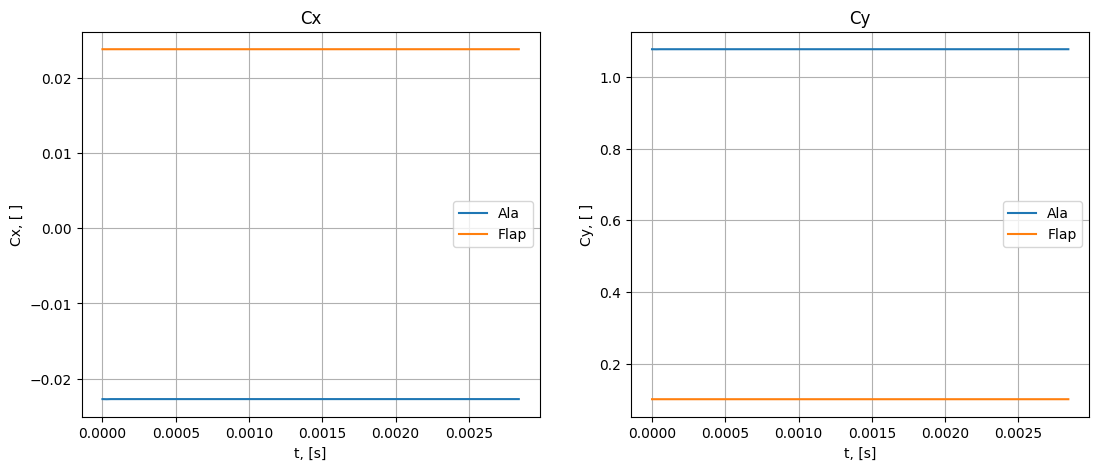

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
mp.plotCAero(ax=ax)
plt.show()

### Campo de $C_p$

Finalmente, se grafica el campo de $C_p$ utilizando un mapa de color.

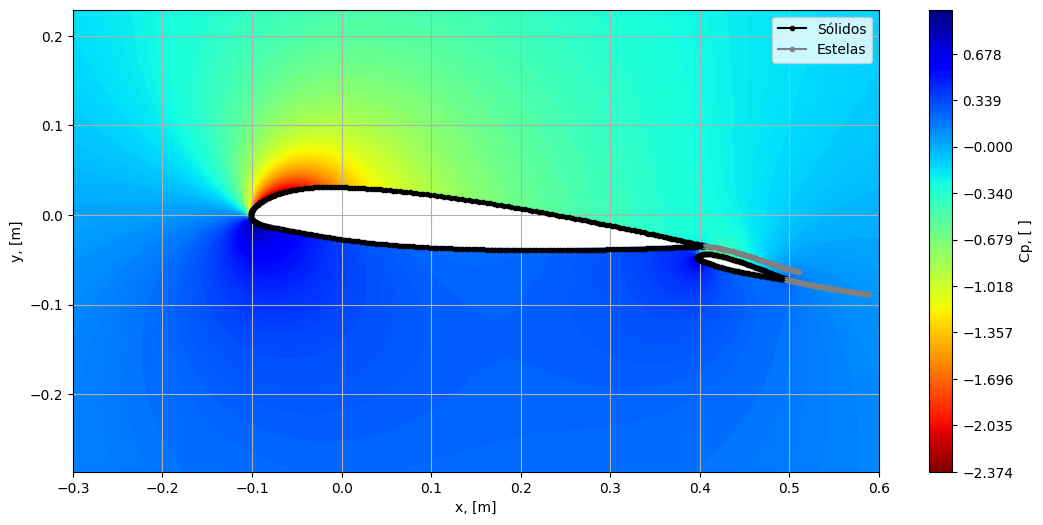

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
mp.plotPaneles(-1, ax=ax)
x = np.linspace(-0.3, 0.9, 250)
y = np.linspace(-0.3, 0.3, 250)
mp.plotCampo_Cp(-1, x, y, ax=ax)

ax.set_xlim(-0.3, 0.6)
plt.show()

A continuación se muestra un detalle de la sección posterior del conjunto para hacer notar algunos detalles.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


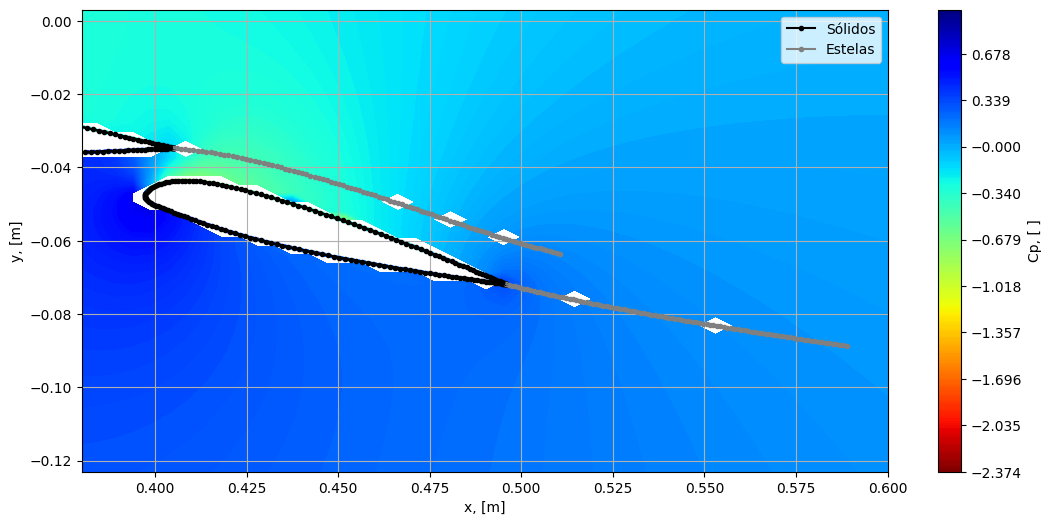

In [16]:
ax.set_xlim(0.38, 0.6)
ax.set_ylim(-0.1, -0.02)
fig.canvas.draw()
display(fig)

En las figuras se puede notar cómo la estela convecta con el campo de velocidades. Sobre esto mismo, también se debe entender que la forma en que lo hace depende de la discretización del tiempo utilizada, empeorando la fidelidad de la simulación cuanto más gruesa sea esta, incluso poniendo en riesgo la impenetrabilidad de los sólidos.

Luego, puede advertirse que sobre el propio sólido se dibujaron círculos con el mismo mapa de color, indicando el $C_p$ en los puntos de colocación. Además, se puede apreciar que este coincide, dentro de lo posible, con el del campo exterior.

Lo anterior, también trae a colación que a veces existe una discrepancia en los colores observados en el flujo exterior y el tangente al sólido. Esto se debe a la discretización con dobletes constantes, que implican vórtices puntuales en los puntos de colocación. Si un punto de evaluación en el campo exterior de la grilla con la que se construyen los mapas de color, se acerca a estos vórtices, la velocidad allí se encuentra en un entorno singular y produce un $C_p$ defectuoso. 

A raíz de esto último, el método de visualización filtra valores de $C_p$ que exceden los valores máximo y mínimo en las superficies de los sólidos, pues las mayores perturbaciones se encuentran sobre sus superficies y en el resto del flujo los valores tienden a $0$. A esto se deben los agujeros blancos en las estelas: algunos puntos de evaluación quedaron próximos a algunos nodos de las estelas, produjeron $C_p$ anormales y se filtraron. En otros casos, los valores excesivos de $C_p$, producto de la proximidad a los nodos, no son lo suficientemente grandes como para ser filtrados y quedan como defectos de la visualización.

## Campo de velocidades relativas

Ahora se muestra el campo de velocidades relativas.

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


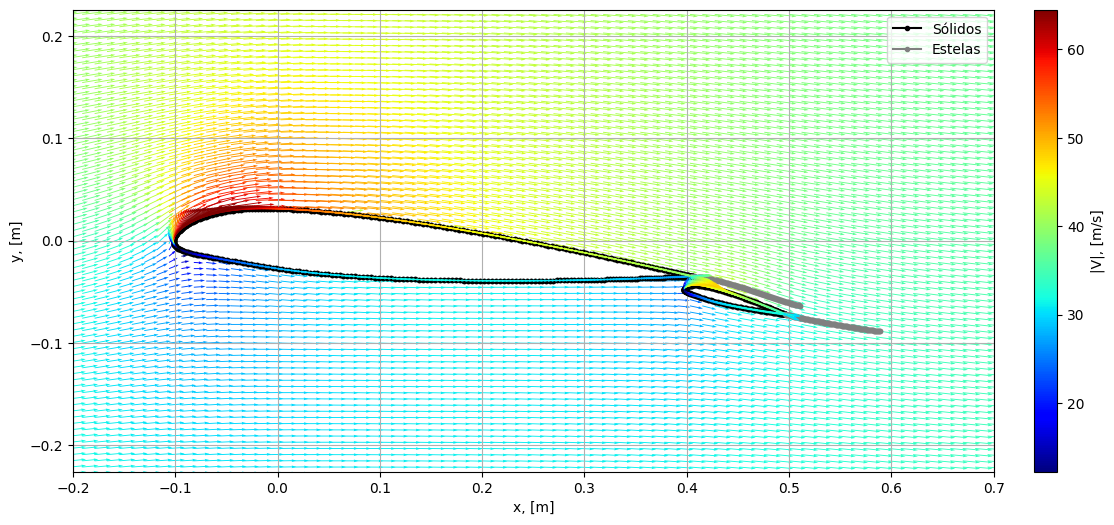

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


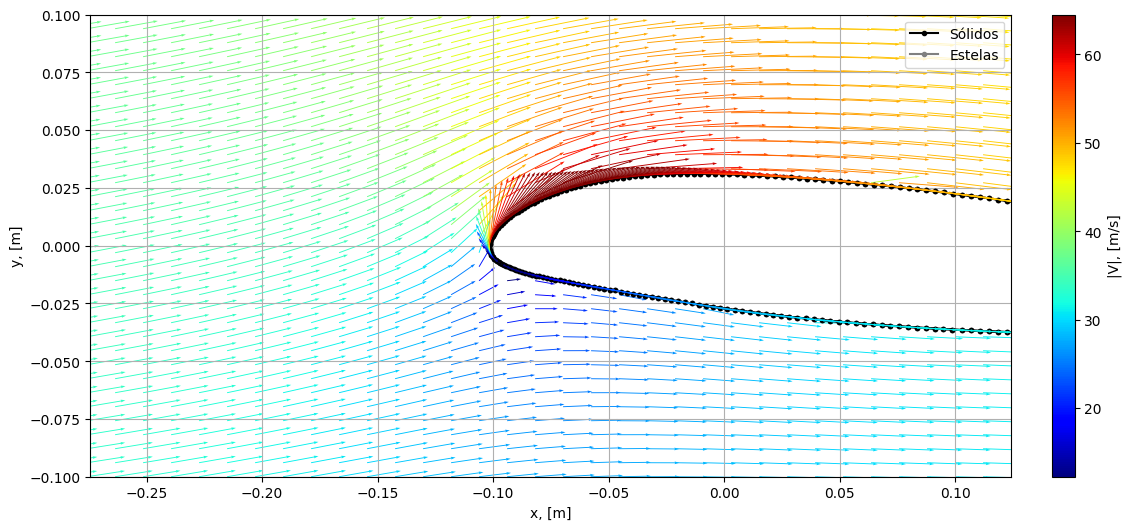

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


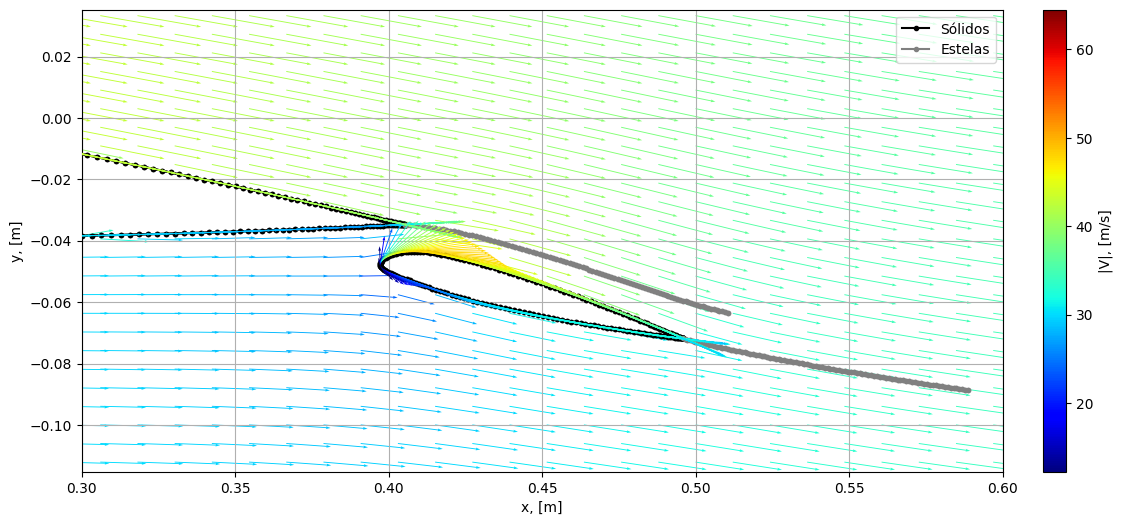

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(13, 6))
x = np.linspace(-0.3, 0.9, 100)
y = np.linspace(-0.3, 0.3, 100)
mp.plotCampo_V(-1, x, y, ax=ax, VRel=True, escala=0.0005, radius=-1e-3)
ax.set_xlim(-0.2, 0.7)
ax.set_ylim(-0.2, 0.2)
plt.show()

ax.set_xlim(-0.15, 0)
ax.set_ylim(-0.1, 0.1)
fig.canvas.draw()
display(fig)

ax.set_xlim(0.3, 0.6)
ax.set_ylim(-0.1, 0.02)
fig.canvas.draw()
display(fig)

El campo graficado es el de velocidades relativas y no el de absolutas, que son las que calcula el método de los paneles. En el caso no estacionario, esta visualización solo tiene sentido si se considera un único sólido o si el conjunto de sólidos se mueve rígidamente entre sí. Lo que se graficaría es $V_{relativa} = V - V_{cinemática}$, donde $V$ es la velocidad del fluido respecto al marco global y $V_{cinemática}$ la velocidad de transporte de la terna solidaria al conjunto.